# Melanoma Detection using CNN

## Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from glob import glob
from pathlib import Path
from collections import Counter

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [49]:
# Setting the tensorflow verbosity level to 'ERROR'

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Loading the dataset

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The dataset contains 2357 images of different skin cancer types. There are a total of 9 classes. The folder contains two sub-directories - train and test, each of which have 9 different sub-directories corresponding to the diffrent cancer classes.

In [51]:
!ls

gdrive	sample_data


In [52]:
# Defining the path for train and test images
data_dir_train = Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [53]:
# Getting the count of the train and test images

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [54]:
batch_size = 32
img_height = 180
img_width = 180

We will use 80% of the images for training, and 20% for validation (from the training set).

Passing the training data directory and resizing the images to the specified height and width for both the training and the validation datasets. Also, specifying the batch size for training and validation.

In [55]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Let us take a look at all the classes present in the given dataset.

In [57]:
# List of all the different classes in the dataset
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

Let us visualize an example from each of the 9 classes.

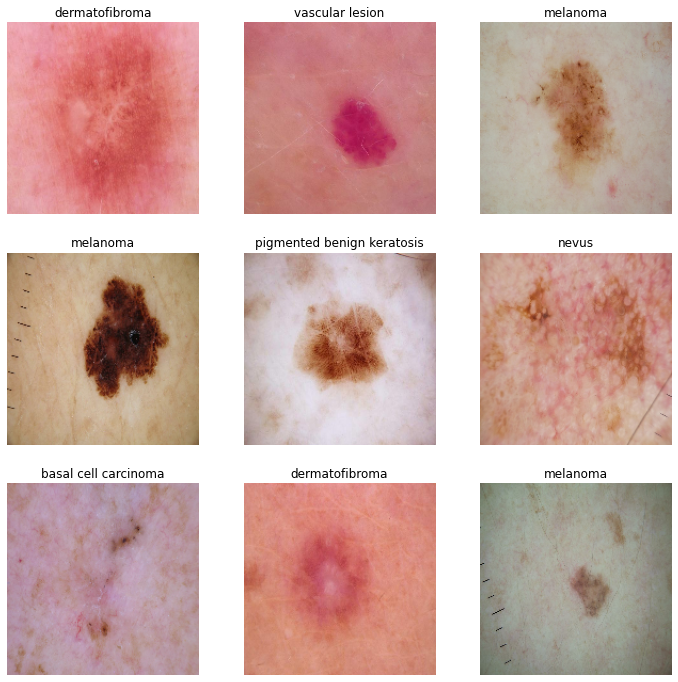

In [58]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Define the model

Let us create the first CNN model.

Resclaing the pixel values to have a value between 0 and 1 as that makes it more efficient.

In [60]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.AveragePooling2D(padding='same'),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.AveragePooling2D(padding='same'),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.AveragePooling2D(padding='same'),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(num_classes),
  layers.Activation('softmax')
])

### Compile the model 

We are using the Adam optimizer (Adaptive Momentum) and have selected the loss as sparse_categorical_crossentopy. The metric being used to judge the performance is accuracy.

In [61]:
# Compiling the model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 90, 90, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 45, 45, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [63]:
# Training the model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 37s 61ms/step - loss: 1.8818 - accuracy: 0.2839 - val_loss: 1.6688 - val_accuracy: 0.3504
Epoch 2/20
169/169 [==============================] - 3s 19ms/step - loss: 1.5663 - accuracy: 0.3958 - val_loss: 1.4727 - val_accuracy: 0.4588
Epoch 3/20
169/169 [==============================] - 3s 20ms/step - loss: 1.3897 - accuracy: 0.4766 - val_loss: 1.3261 - val_accuracy: 0.5033
Epoch 4/20
169/169 [==============================] - 3s 19ms/step - loss: 1.2806 - accuracy: 0.5096 - val_loss: 1.3298 - val_accuracy: 0.5019
Epoch 5/20
169/169 [==============================] - 3s 19ms/step - loss: 1.1678 - accuracy: 0.5569 - val_loss: 1.5615 - val_accuracy: 0.4469
Epoch 6/20
169/169 [==============================] - 4s 21ms/step - loss: 1.0835 - accuracy: 0.5979 - val_loss: 1.3243 - val_accuracy: 0.5271
Epoch 7/20
169/169 [==============================] - 3s 20ms/step - loss: 0.9753 - accuracy: 0.6437 - val_loss: 1.1561 - val_accuracy: 0.565

### Visualizing training results

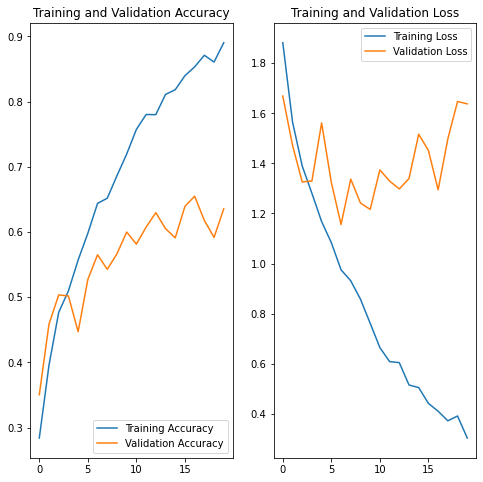

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from graphs, the model is clearly overfitting on the data. This can be handled using data augmentation and adding regularization (in the form of dropout, batch normalisation and L2 regularisation).

Also, the data can be augmented to create a more diverse dataset so that the model can be more generisable and robust. Various transformations like flipping, rotation, zoom and translation are applied to the images.

In [65]:
# Using data augmentation to create a more varied training dataset

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.3,
                                                 width_factor=0.3),
    layers.experimental.preprocessing.RandomTranslation(0.3, 0.3),
    layers.experimental.preprocessing.RandomContrast(0.2)
  ]
)

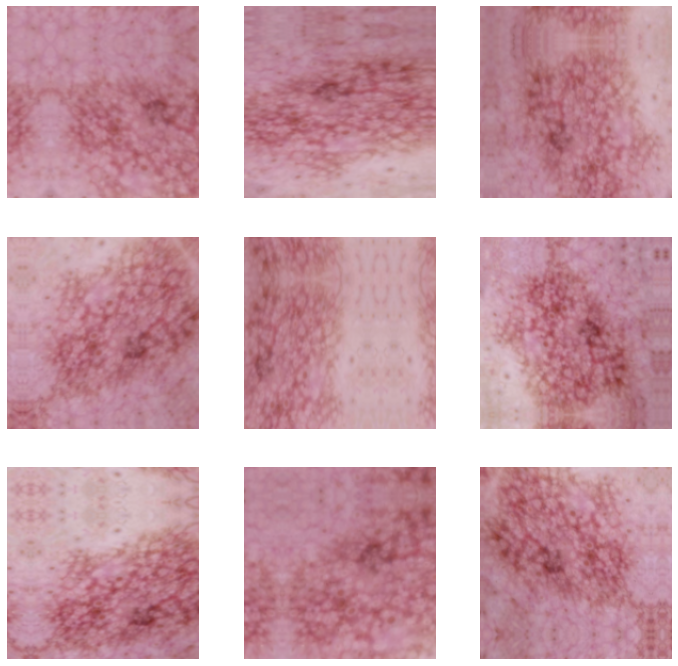

In [66]:
# Visualizing an instance of the augmented data 

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Defining the model

In [67]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.AveragePooling2D(padding='same'),
  layers.Dropout(0.2),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(padding='same'),
  layers.Dropout(0.3),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.AveragePooling2D(padding='same'),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(padding='same'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02), kernel_initializer='he_uniform'),
  layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Activation('softmax')
])

### Compiling the model

We are using the Adam optimizer (Adaptive Momentum) and have selected the loss as sparse_categorical_crossentopy. The metric being used to judge the performance is accuracy.

In [68]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
# View the summary of all layers

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 average_pooling2d_3 (Averag  (None, 90, 90, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout_10 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_8 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                      

### Training the model

In [70]:
# Using 20 epochs for training

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 9s 32ms/step - loss: 3.8840 - accuracy: 0.3783 - val_loss: 3.2126 - val_accuracy: 0.1143
Epoch 2/20
169/169 [==============================] - 5s 32ms/step - loss: 2.0052 - accuracy: 0.4618 - val_loss: 2.3114 - val_accuracy: 0.2843
Epoch 3/20
169/169 [==============================] - 5s 32ms/step - loss: 1.7397 - accuracy: 0.4981 - val_loss: 2.2983 - val_accuracy: 0.3437
Epoch 4/20
169/169 [==============================] - 5s 33ms/step - loss: 1.6284 - accuracy: 0.5354 - val_loss: 1.9005 - val_accuracy: 0.4388
Epoch 5/20
169/169 [==============================] - 5s 32ms/step - loss: 1.5518 - accuracy: 0.5575 - val_loss: 2.2145 - val_accuracy: 0.4157
Epoch 6/20
169/169 [==============================] - 5s 32ms/step - loss: 1.5181 - accuracy: 0.5625 - val_loss: 1.5962 - val_accuracy: 0.5382
Epoch 7/20
169/169 [==============================] - 5s 32ms/step - loss: 1.4883 - accuracy: 0.5838 - val_loss: 1.7673 - val_accuracy: 0.5011

### Visualizing the results

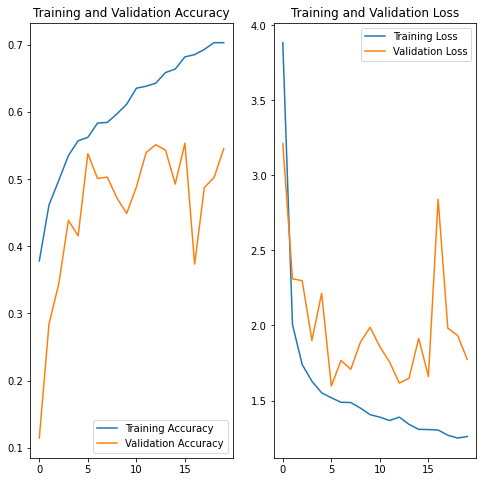

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the graphs above, the problem of overfitting has been reduced but it is still there. Also, the training accuracy is just 70% indicating a little bit of underfitting which may be resolved using a higher number of epochs, changing the architecture or having more data in which there is very little class imbalance.

Let us see the number of images in each class.

In [72]:
path_list = [filepath for filepath in Path(data_dir_train).rglob('*.jpg')]
label_list = [str(path).split('/')[-2] for path in path_list]
print(len(path_list))
print(len(label_list))

2239
2239


In [73]:
dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()), columns=['Path', 'Label'])
original_df.head()

,Path,Label
0,gdrive/MyDrive/Skin cancer ISIC The Internatio...,pigmented benign keratosis
1,gdrive/MyDrive/Skin cancer ISIC The Internatio...,pigmented benign keratosis
2,gdrive/MyDrive/Skin cancer ISIC The Internatio...,pigmented benign keratosis
3,gdrive/MyDrive/Skin cancer ISIC The Internatio...,pigmented benign keratosis
4,gdrive/MyDrive/Skin cancer ISIC The Internatio...,pigmented benign keratosis


In [74]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

As we can see, the classes 'seborrheic keratosis' and 'dermatofibroma' have the least number of samples. Also, the classes 'pigmented benign keratosis' and 'melaoma' dominate the dataset.

Let us see plot the frequency of each class.

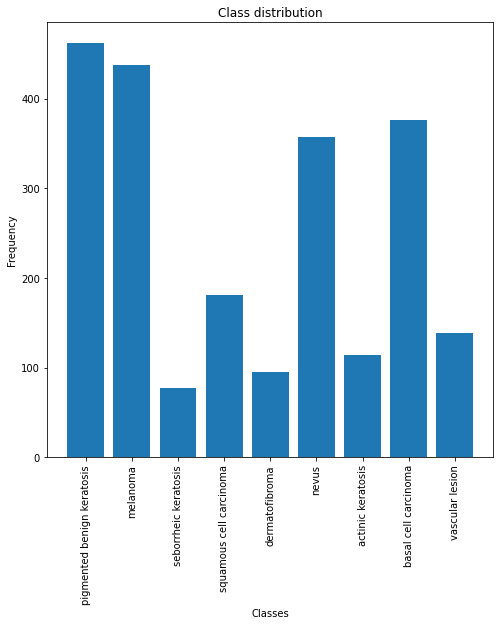

In [75]:
class_count = Counter(label_list)

figure = plt.figure(figsize=(8, 8))

plt.bar(class_count.keys(), class_count.values())
plt.title('Class distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

Thus, it is clear that there is a class imbalance which needs to be dealt with. We will use the Augmentor library to generate images of each class to handle the class imbalance.

Installing the Augmentor library

In [76]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


Adding various transformations to the generated images to ensure that they are not identical copies.

In [77]:
import Augmentor

path_to_training_dataset=data_dir_train

for cls in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset/cls)
  p.rotate(probability=0.4, max_left_rotation=10, max_right_rotation=10)
  p.skew(probability=0.4)
  p.random_distortion(probability=0.44, grid_width=5, grid_height=5, magnitude=5)
  p.flip_random(probability=0.4)
  p.sample(500)   ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F37C42BBC70>: 100%|██████████| 500/500 [00:26<00:00, 18.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F37C4286B80>: 100%|██████████| 500/500 [00:26<00:00, 18.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F37C42832B0>: 100%|██████████| 500/500 [00:28<00:00, 17.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F37C430A5E0>: 100%|██████████| 500/500 [02:28<00:00,  3.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=957x723 at 0x7F37C4254F40>: 100%|██████████| 500/500 [02:20<00:00,  3.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F37C42CEFA0>: 100%|██████████| 500/500 [00:26<00:00, 18.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F37C43DC0A0>: 100%|██████████| 500/500 [01:02<00:00,  7.96 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F37C43AEA60>: 100%|██████████| 500/500 [00:27<00:00, 18.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F37C43159D0>: 100%|██████████| 500/500 [00:26<00:00, 18.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [78]:
# Let us count the number of augmented images generated

image_count_train = len(list(Path(data_dir_train).rglob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [80]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
len(path_list_new)

4500

In [81]:
label_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(label_list_new)

4500

In [82]:
dataframe_dict_new = dict(zip(path_list_new, label_list_new))

In [83]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = original_df.append(df2)

In [84]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

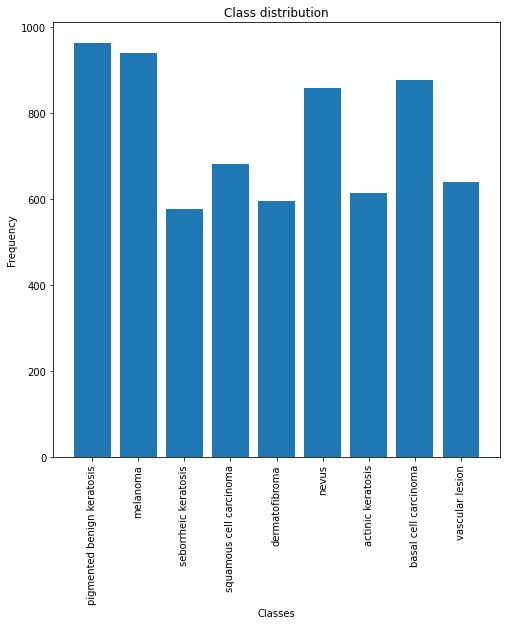

In [86]:
class_count = Counter(new_df['Label'])

figure = plt.figure(figsize=(8, 8))

plt.bar(class_count.keys(), class_count.values())
plt.title('Class distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Defining the dataset parameters

In [87]:
batch_size = 32
img_height = 180
img_width = 180

Training dataset - It has the original images + the images generated using augmentor.

In [88]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Validation dataset - It has the original images + the images generated using augmentor.

In [89]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Defining the model

In [90]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
  layers.Dropout(0.3),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02), kernel_initializer='he_uniform'),
  layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Activation('softmax')
])

### Compiling the model

In [91]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
# Checking the model summary

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_10 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 average_pooling2d_7 (Averag  (None, 90, 90, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout_14 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)       

### Training the model

In [93]:
# Using 30 epochs for training

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 50s 81ms/step - loss: 5.2732 - accuracy: 0.3958 - val_loss: 5.2127 - val_accuracy: 0.1225
Epoch 2/30
169/169 [==============================] - 7s 41ms/step - loss: 2.6734 - accuracy: 0.4777 - val_loss: 3.6498 - val_accuracy: 0.2012
Epoch 3/30
169/169 [==============================] - 7s 41ms/step - loss: 2.1444 - accuracy: 0.5197 - val_loss: 2.5876 - val_accuracy: 0.3370
Epoch 4/30
169/169 [==============================] - 7s 42ms/step - loss: 1.9603 - accuracy: 0.5508 - val_loss: 2.1280 - val_accuracy: 0.4759
Epoch 5/30
169/169 [==============================] - 7s 43ms/step - loss: 1.8718 - accuracy: 0.5784 - val_loss: 2.2627 - val_accuracy: 0.4454
Epoch 6/30
169/169 [==============================] - 7s 42ms/step - loss: 1.8159 - accuracy: 0.5857 - val_loss: 2.4513 - val_accuracy: 0.4202
Epoch 7/30
169/169 [==============================] - 7s 42ms/step - loss: 1.7353 - accuracy: 0.6014 - val_loss: 2.2084 - val_accuracy: 0.466

### Visualizing the results

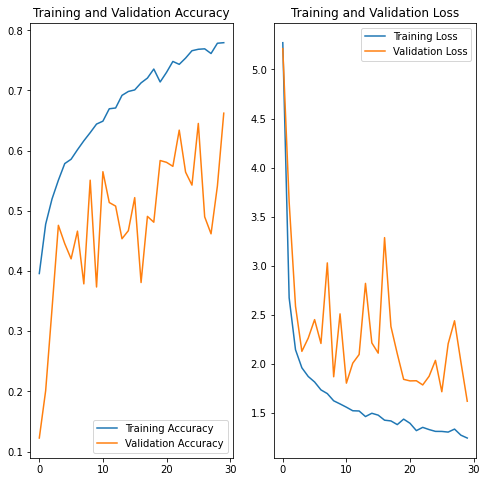

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see, handling the class imbalance did help in reducing overfitting and as well as underfitting to some extent. The model can be further improved by using more training data (diverse and with very little class imbalance), different architectures (more CNN and pooling layers, different activation functions, different initializers), different hyperparameter value combinations for each hyperparameter, and training the model for more number of epochs.